# Make predictions from the pre-trained model on given test data

In [1]:
import numpy as np
from tensorflow.keras import models
import matplotlib.pyplot as plt

# Load utility functions for preparing dataset
from utils.preparedata import prepare_samples4prediction, restore_from_patches

Set the parameters

In [2]:
n_test = 25
img_w = img_h = 256

in_model_file = './model.json'
in_weights_file = './checkpoint'  # './model_weights_final_eps50.hdf5'

Load test data

In [3]:
data = prepare_samples4prediction(n=n_test, img_h=img_h, img_w=img_w,
                                  max_val=130., verbose=True)

All training data has been loaded from ./data/train
	shapes: (1600, 256, 256, 1)
	types:  uint8
	memory: 100.0 MB


Load the model structure and the pre-trained weights

In [4]:
with open(in_model_file) as model_file:
    autoencoder = models.model_from_json(model_file.read())

autoencoder.load_weights(in_weights_file)

Predict outputs

In [5]:
outputs = autoencoder.predict(data, verbose=False)
predictions = np.argmax(outputs, axis=-1).astype(bool)

Plot results

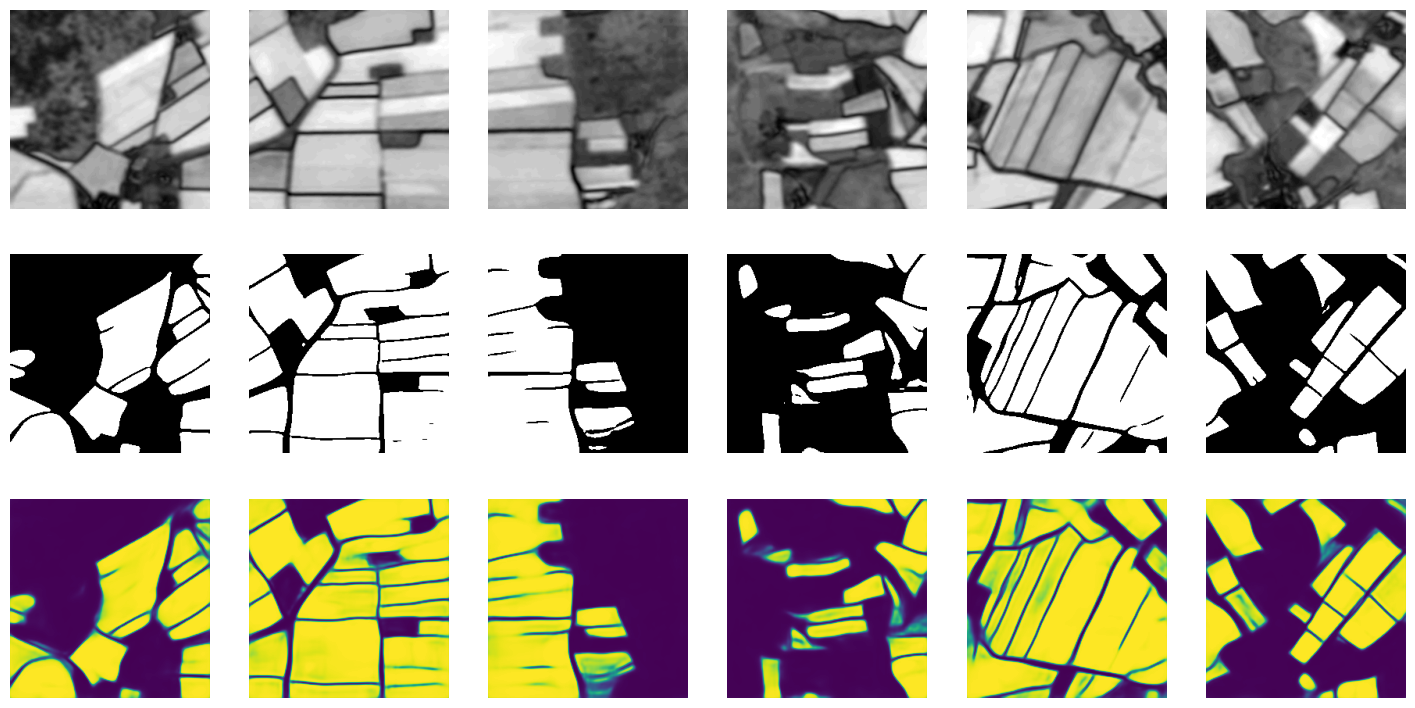

In [6]:
n_show_samples = 6
plt.figure(figsize=(3 * n_show_samples, 9))
for k in range(n_show_samples):
    img = data[k, :, :, 0]
    out = outputs[k, :, :, 1]
    pred = predictions[k]

    plt.subplot(3, n_show_samples, k + 1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    if k == 0:
        plt.ylabel('Image')

    plt.subplot(3, n_show_samples, n_show_samples + k + 1)
    plt.axis('off')
    plt.imshow(pred, cmap='gray')
    if k == 0:
        plt.ylabel('Prediction')

    plt.subplot(3, n_show_samples, 2*n_show_samples + k + 1)
    plt.axis('off')
    plt.imshow(out)
    if k == 0:
        plt.ylabel('Heat Map')
plt.show()

Restore all 25 full 2000x2000 images and relative predictions from their patches

In [7]:
images = restore_from_patches(data[..., 0], (2000, 2000))
final_predictions = restore_from_patches(predictions, (2000, 2000))

# Submit the results

Export geotif binary output maps in the submission folder (and compress to .tar.gz) as defined in the starter pack.

**NOTE:** remove any other file that is not a `.tif` file from the submission folder.

**NOTE:** make sure all pixels in the submitted tiffs are valid pixels, e.g. they are not set as `NO_DATA`.

**NOTE:** the scoring system will perform the following checks on the submitted files:
   * assert that the submission contains 25 files with the correct name, e.g. `eopatch-01.tif` to `eopatch-25.tif`;
   * assert that each file has a single band of size `2000x2000` pixels;
   * assert that the bounding box coordinates match the corresponding anonymised ones. Although the coordinates are randomised, working with geo-referenced images allows us to visually inspect them and compared them to the reference labels in any GIS software;
   * assert that the predicted images are binary, i.e. the only values it contains are `[0, 1]`.

In [9]:
import os
from eolearn.core import (FeatureType,
                          AddFeature,
                          EOPatch,
                          LoadTask)
from eolearn.io import ExportToTiff

In [10]:
SUBMISSION_DIR = 'submission'

if not os.path.exists(SUBMISSION_DIR):
    os.makedirs(SUBMISSION_DIR)

/opt/conda/envs/eurodatacube-gpu-0.24.5/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
load = LoadTask(path='./eopatches/test')
for i in range(n_test):
    id_str = str(i+1) if (i+1) > 9 else '0'+str(i+1)
    eop = load.execute(eopatch_folder=f'eopatch-' + id_str)  
    bbox = eop.bbox
    eopatch = EOPatch(bbox=bbox)
    add_feature = AddFeature((FeatureType.MASK_TIMELESS, 'PREDICTION'))
    eopatch = add_feature.execute(eopatch, final_predictions[i, ..., None])
    task = ExportToTiff((FeatureType.MASK_TIMELESS, 'PREDICTION'),
                        folder=SUBMISSION_DIR, band_indices=[0],
                        crs='epsg:32633', image_dtype=np.uint8, no_data_value=255)
    task.execute(eopatch, filename="eopatch-" + id_str + ".tif")

In [12]:
!ls -al {SUBMISSION_DIR}

total 97812
drwxr-sr-x  3 jovyan users    6144 Sep 30 09:49 .
drwxrws--x 37 root   users    6144 Sep 30 09:48 ..
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:48 eopatch-01.tif
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:48 eopatch-02.tif
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:48 eopatch-03.tif
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:48 eopatch-04.tif
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:48 eopatch-05.tif
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:48 eopatch-06.tif
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:49 eopatch-07.tif
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:49 eopatch-08.tif
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:49 eopatch-09.tif
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:49 eopatch-10.tif
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:49 eopatch-11.tif
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:49 eopatch-12.tif
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:49 eopatch-13.tif
-rw-r--r--  1 jovyan users 4004372 Sep 30 09:49 eopatch-14.tif
-rw-r

**NOTE:** you can now compress (to a `.zip` or to a `.tar.gz` file) the `submission` folder and submit it for evaluation.

In [13]:
!tar -C {SUBMISSION_DIR} -zcvf submission.tar.gz .

./
./eopatch-24.tif
./eopatch-06.tif
./eopatch-15.tif
./eopatch-20.tif
./eopatch-02.tif
./eopatch-11.tif
./eopatch-19.tif
./eopatch-08.tif
./eopatch-17.tif
./.ipynb_checkpoints/
./eopatch-22.tif
./eopatch-04.tif
./eopatch-13.tif
./eopatch-25.tif
./eopatch-07.tif
./eopatch-16.tif
./eopatch-21.tif
./eopatch-03.tif
./eopatch-12.tif
./eopatch-01.tif
./eopatch-10.tif
./eopatch-09.tif
./eopatch-18.tif
./eopatch-23.tif
./eopatch-05.tif
./eopatch-14.tif


View some of the results

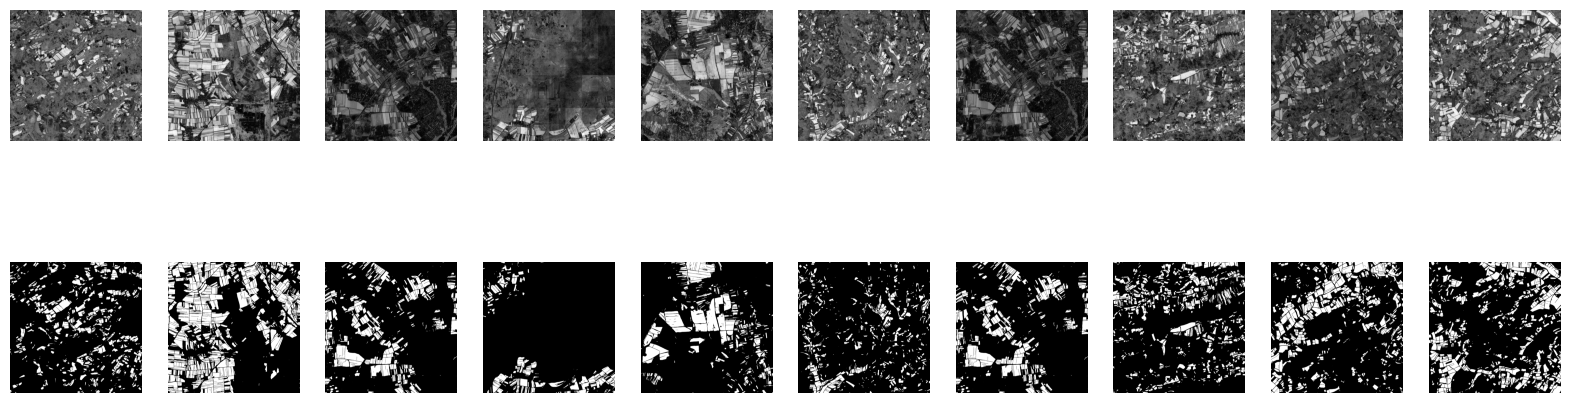

In [14]:
n_show_predicted = 10
ids = np.random.randint(0, n_test, n_show_predicted)

plt.figure(figsize=(2 * n_show_predicted, 6))
for k, ind in enumerate(ids):
    img = images[ind]
    pred = final_predictions[ind]

    plt.subplot(2, n_show_predicted, k+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    if k == 0:
        plt.ylabel('Image')

    plt.subplot(2, n_show_predicted, n_show_predicted+k+1)
    plt.axis('off')
    plt.imshow(pred, cmap='gray')
    if k == 0:
        plt.ylabel('Prediction')
plt.show()